In [2]:
import numpy as np
import openpyxl.utils
%matplotlib inline

import torch
import pylab as plt
from munch import munchify
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

from utils import *
from tqdm import tqdm
# from preprocessing.s02_create_dataset import load_cores_h5py

In [3]:
# project root
project_root = 'C:/Users/Mahdi/Desktop/Summer21/RA/Codes/Minh_Mahdi_mod/prostate_cancer_classification'

args = {}

# yaml configuration file location
args['config'] = '../yamls/coteaching_local_inference_Exact2D.yml'

# experiment location to load
args['exp_suffix'] = '_Patch/1e-4_onecycleNovo_fr.4numgrad6----inv.7train.4test_res10_UVA400_srs26_vs.4'
# args['exp_suffix'] = '_Patch/1e-4_onecycleNovo_fr.4numgrad6----res10_UVA400_srs26_vs.4'

# opt is a dictionary which contains all configurations
with open(args['config']) as f:
    opt = yaml.load(f, Loader)
opt.update(args)
opt = munchify(opt)
opt.project_root = project_root
opt = setup_directories(opt)

# num_workers = 0
# device = torch.device(f'cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
# # creating the neural network
# net = construct_network(device, opt)
# net = net[0]()
#
# # loading the saved weights to it
# suffix = '_1'
# net.load_state_dict(torch.load(f'{opt.project_root}/{opt.paths.checkpoint_dir}/{opt.test.which_iter}_coreN{suffix}.pth'))

In [5]:
# datafile to load the data. This cell and the next cell are just for having some sense of how to feed data.
# Please load your own data and make them similar to the shape of data in dataset.
data_file = '/'.join([opt.data_source.data_root, opt.data_source.test_set])
print('loading data...')
input_data = load_matlab(data_file)
print('loading done!')

loading data...
loading done!


In [6]:
from utils.dataset import merge_split_train_val
split_rs = 26
val_size = 0.4

if split_rs>=0:
    input_data = merge_split_train_val(input_data, random_state=split_rs, val_size=val_size)

In [7]:
from utils.dataset import create_datasets_test_Exact

initial_min_inv=.8
min_inv=.4

# which dataset to use for testset. Either train, val, or test
state = 'test'
dataset, core_len, true_involvement, patient_id_bk, gs_bk, roi_coors, true_labels, *ids = create_datasets_test_Exact(
    '/'.join([opt.data_source.data_root, opt.data_source.test_set]), dataset_name=opt.data_source.dataset,
    min_inv=min_inv, input_data=input_data, state=state, norm=opt.normalize_input)

cancer labels shape (1333, 2)
data shape (3483, 1, 256, 256)


In [8]:
# these are input data and label corresponding to them
# label is just for plotts in the next cell, you can feed a random matrix of nx2 instead
x_data = dataset.tensors[0]
y_label = dataset.tensors[1]

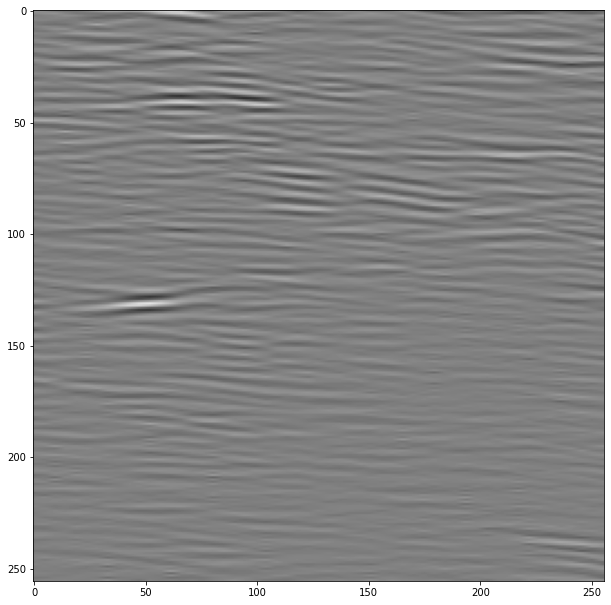

In [9]:
import matplotlib.pyplot as plt
from matplotlib.colors import NoNorm
from matplotlib.colors import TwoSlopeNorm
from einops import rearrange

fig = plt.figure(figsize=(18.5, 10.5))
ax = fig.add_subplot()
plt.imshow(x_data[0,0,...], cmap='gray',norm=TwoSlopeNorm(0,-10,10))
# plt.imshow(x_data[0,0,...], cmap='gray',norm=NoNorm())
plt.show()

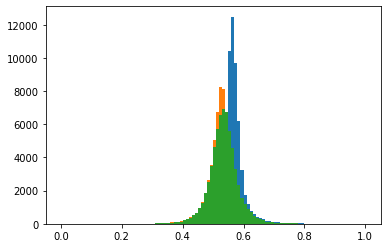

In [10]:
for i in [2600,2000, 2501]:
    x = rearrange(np.copy(x_data[i,...].numpy()), 'c h w -> h w c')
    # x[x>4]=4.
    # x[x<-4]=-4.
    min_ = x.min(axis=(0, 1)).reshape(1,1,-1)
    max_ = x.max(axis=(0, 1)).reshape(1,1,-1)
    new_x = (x - min_)/(max_ - min_)
    # plt.hist(x.reshape(-1), bins=np.arange(-5,5.1,.1))
    plt.hist(new_x.reshape(-1), bins=np.arange(0,1.01,0.01))
plt.show()

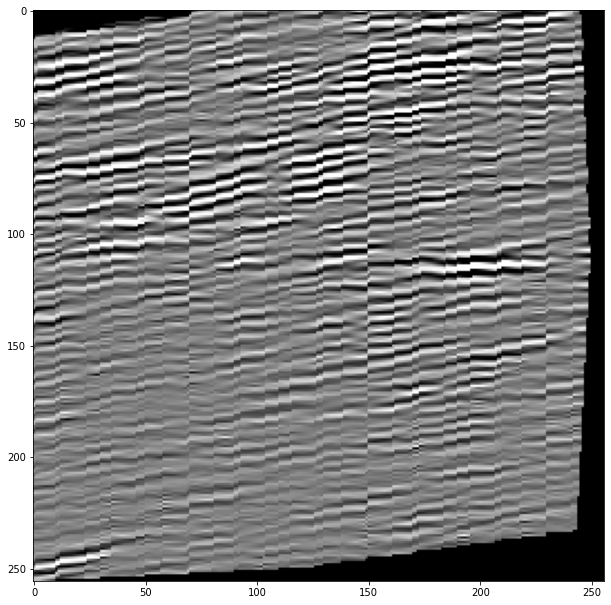

In [93]:
from utils.aug import *
from PIL import Image

# aug_type = ['Flip','Invert','Rotate','ShearX','ShearY','TranslateXabs',
# 'TranslateYabs','Sharpness']
aug_type = ['Identity','Flip','Rotate','ShearX','ShearY',]
transform, _ = get_imgtransform(aug_type, .2)

j = 0
x = rearrange(np.copy(x_data[j,...].numpy()), 'c h w -> h w c')
x_label = y_label[j,...].numpy()
# x[(x>1.) | (x< -2.)] = 0.
x[(x > 2.)] = 2.
x[(x< -2.)] = -2.
# x = x/x.max()
x = (x - x.min())/(x.max()-x.min())
# x = np.uint8(x[:,:,0]*255.)
# pil_image=Image.fromarray(x)
transformed = transform(x)
# transformed = transform(x)

fig = plt.figure(figsize=(18.5, 10.5))
ax = fig.add_subplot()
plt.imshow(transformed, cmap='gray',norm=NoNorm())
plt.show()

In [24]:
# from sklearn.preprocessing import RobustScaler
#
# transformer = RobustScaler().fit(x[...,0])
# y = transformer.transform(x[...,0])
#
# fig = plt.figure(figsize=(18.5, 10.5))
# ax = fig.add_subplot()
# plt.imshow(y, cmap='gray', )
# plt.show()